In [66]:
import pickle
import string
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import multilabel_oversampling as mo

In [67]:
df = pd.read_csv('train.En.csv')
df = df[df['sarcastic'] == 1]

df = df[['tweet', 'sarcasm', 'irony', 'satire', 'understatement', 'overstatement', 'rhetorical_question']]
target_names = ['sarcasm', 'irony', 'satire', 'understatement', 'overstatement', 'rhetorical_question']
df = df.dropna(subset=['tweet'])
df.head(3)

,tweet,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,The only thing I got from college is a caffein...,0.0,1.0,0.0,0.0,0.0,0.0
1,I love it when professors draw a big question ...,1.0,0.0,0.0,0.0,0.0,0.0
2,Remember the hundred emails from companies whe...,0.0,1.0,0.0,0.0,0.0,0.0


In [68]:
df['tweet'] = df['tweet'].str.replace('[^\w\s]', '')  # getting rid of special characters
df['tweet'] = df['tweet'].str.replace('\d+', '')  # removing numeric values from between the words
df['tweet'] = df['tweet'].apply(
    lambda x: x.translate(string.digits))  # removing numerical numbers
df['tweet'] = df['tweet'].apply(
    lambda x: " ".join(x.lower() for x in x.split()))  # lower case conversion
stop = stopwords.words('english')
df['tweet'] = df['tweet'].apply(
    lambda x: " ".join(x for x in x.split() if x not in stop))  # removing stop words
stemmer = WordNetLemmatizer()
df['tweet'] = [stemmer.lemmatize(word) for word in df['tweet']]  # converting words to their dictionary form

C:\Users\abdul\AppData\Local\Temp\ipykernel_15536\2835670012.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['tweet'] = df['tweet'].str.replace('[^\w\s]', '')  # getting rid of special characters
C:\Users\abdul\AppData\Local\Temp\ipykernel_15536\2835670012.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['tweet'] = df['tweet'].str.replace('\d+', '')  # removing numeric values from between the words


In [69]:
mo.seed_everything(20)
# df = mo.create_fake_data(size=1) # difficult fake dataset with very high dependency of y1 and y2
ml_oversampler = mo.MultilabelOversampler(number_of_adds=2000, number_of_tries=1000)
df_new = ml_oversampler.fit(df, target_list=target_names)

Start the upsampling process.


Iteration:  15%|██████████▏                                                         | 300/2000 [00:28<02:40, 10.61it/s]

Iter 300: No improvement after 1000 tries.
Sampling done.

Dataset size original: 867; Upsampled dataset size: 1167
Original target distribution:  {'sarcasm': 713.0, 'irony': 155.0, 'satire': 25.0, 'understatement': 10.0, 'overstatement': 40.0, 'rhetorical_question': 101.0}
Upsampled target distribution: {'sarcasm': 713.0, 'irony': 455.0, 'satire': 98.0, 'understatement': 97.0, 'overstatement': 112.0, 'rhetorical_question': 173.0}


In [70]:
X = df_new['tweet']
y = df_new[['sarcasm', 'irony', 'satire', 'understatement', 'overstatement', 'rhetorical_question']]

tfidf_vectorizer = TfidfVectorizer(max_features=200)
tfidf_vectorizer.fit(X)
X_feat = tfidf_vectorizer.transform(X)

# Save the TfidfVectorizer object
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

X_train, X_test, y_train, y_test = train_test_split(X_feat, y, test_size=0.3, random_state=42)

X_train = X_train.toarray()
X_test = X_test.toarray()

In [71]:
model = Sequential()
model.add(Dense(256, input_shape=(X_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(6, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=200, validation_data=(X_test, y_test))
model.save('my_model.h5')

Epoch 1/200
26/26 [==============================] - 1s 7ms/step - loss: 0.6015 - accuracy: 0.5956 - val_loss: 0.4884 - val_accuracy: 0.6040
Epoch 2/200
26/26 [==============================] - 0s 3ms/step - loss: 0.4329 - accuracy: 0.6140 - val_loss: 0.4022 - val_accuracy: 0.6040
Epoch 3/200
26/26 [==============================] - 0s 2ms/step - loss: 0.3645 - accuracy: 0.7512 - val_loss: 0.3735 - val_accuracy: 0.7578
Epoch 4/200
26/26 [==============================] - 0s 2ms/step - loss: 0.3232 - accuracy: 0.8627 - val_loss: 0.3632 - val_accuracy: 0.7778
Epoch 5/200
26/26 [==============================] - 0s 3ms/step - loss: 0.2918 - accuracy: 0.8946 - val_loss: 0.3657 - val_accuracy: 0.7806
Epoch 6/200
26/26 [==============================] - 0s 3ms/step - loss: 0.2602 - accuracy: 0.9056 - val_loss: 0.3700 - val_accuracy: 0.7949
Epoch 7/200
26/26 [==============================] - 0s 3ms/step - loss: 0.2387 - accuracy: 0.9191 - val_loss: 0.3791 - val_accuracy: 0.8091
Epoch 8/200
2

Epoch 59/200
26/26 [==============================] - 0s 3ms/step - loss: 0.0485 - accuracy: 0.9412 - val_loss: 0.7062 - val_accuracy: 0.6467
Epoch 60/200
26/26 [==============================] - 0s 3ms/step - loss: 0.0497 - accuracy: 0.9007 - val_loss: 0.7183 - val_accuracy: 0.7721
Epoch 61/200
26/26 [==============================] - 0s 2ms/step - loss: 0.0479 - accuracy: 0.9314 - val_loss: 0.7185 - val_accuracy: 0.7350
Epoch 62/200
26/26 [==============================] - 0s 2ms/step - loss: 0.0480 - accuracy: 0.9118 - val_loss: 0.7233 - val_accuracy: 0.7037
Epoch 63/200
26/26 [==============================] - 0s 2ms/step - loss: 0.0493 - accuracy: 0.9081 - val_loss: 0.7243 - val_accuracy: 0.6724
Epoch 64/200
26/26 [==============================] - 0s 3ms/step - loss: 0.0496 - accuracy: 0.8640 - val_loss: 0.6937 - val_accuracy: 0.7179
Epoch 65/200
26/26 [==============================] - 0s 3ms/step - loss: 0.0470 - accuracy: 0.9081 - val_loss: 0.7303 - val_accuracy: 0.6439
Epoch 

26/26 [==============================] - 0s 2ms/step - loss: 0.0462 - accuracy: 0.8125 - val_loss: 0.7339 - val_accuracy: 0.7322
Epoch 117/200
26/26 [==============================] - 0s 2ms/step - loss: 0.0459 - accuracy: 0.8199 - val_loss: 0.7407 - val_accuracy: 0.6553
Epoch 118/200
26/26 [==============================] - 0s 2ms/step - loss: 0.0460 - accuracy: 0.8885 - val_loss: 0.7560 - val_accuracy: 0.6239
Epoch 119/200
26/26 [==============================] - 0s 2ms/step - loss: 0.0458 - accuracy: 0.7904 - val_loss: 0.7663 - val_accuracy: 0.7379
Epoch 120/200
26/26 [==============================] - 0s 2ms/step - loss: 0.0456 - accuracy: 0.9093 - val_loss: 0.7509 - val_accuracy: 0.6239
Epoch 121/200
26/26 [==============================] - 0s 2ms/step - loss: 0.0456 - accuracy: 0.8076 - val_loss: 0.7653 - val_accuracy: 0.6838
Epoch 122/200
26/26 [==============================] - 0s 2ms/step - loss: 0.0463 - accuracy: 0.8529 - val_loss: 0.7686 - val_accuracy: 0.6809
Epoch 123/200

26/26 [==============================] - 0s 2ms/step - loss: 0.0455 - accuracy: 0.8088 - val_loss: 0.8678 - val_accuracy: 0.6695
Epoch 174/200
26/26 [==============================] - 0s 2ms/step - loss: 0.0453 - accuracy: 0.8100 - val_loss: 0.8732 - val_accuracy: 0.6610
Epoch 175/200
26/26 [==============================] - 0s 2ms/step - loss: 0.0462 - accuracy: 0.8015 - val_loss: 0.9079 - val_accuracy: 0.7322
Epoch 176/200
26/26 [==============================] - 0s 2ms/step - loss: 0.0465 - accuracy: 0.9130 - val_loss: 0.8748 - val_accuracy: 0.6667
Epoch 177/200
26/26 [==============================] - 0s 2ms/step - loss: 0.0456 - accuracy: 0.8885 - val_loss: 0.8675 - val_accuracy: 0.7749
Epoch 178/200
26/26 [==============================] - 0s 2ms/step - loss: 0.0469 - accuracy: 0.8725 - val_loss: 0.8721 - val_accuracy: 0.7664
Epoch 179/200
26/26 [==============================] - 0s 2ms/step - loss: 0.0454 - accuracy: 0.9412 - val_loss: 0.8968 - val_accuracy: 0.6496
Epoch 180/200

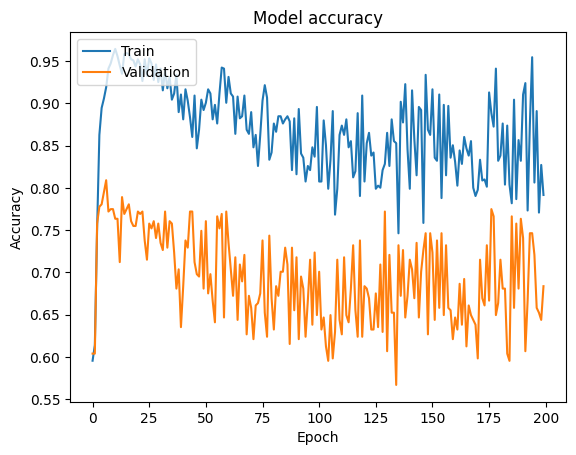

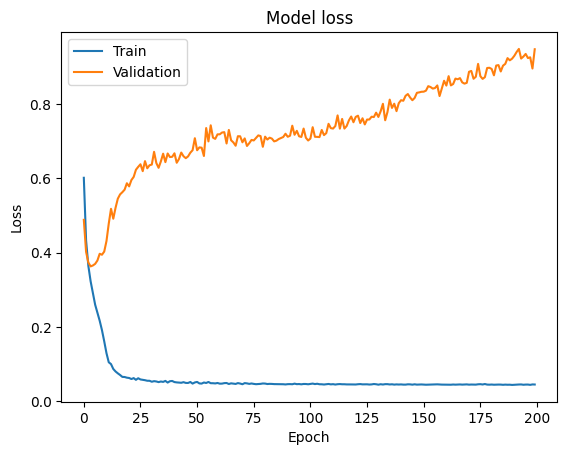

In [72]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


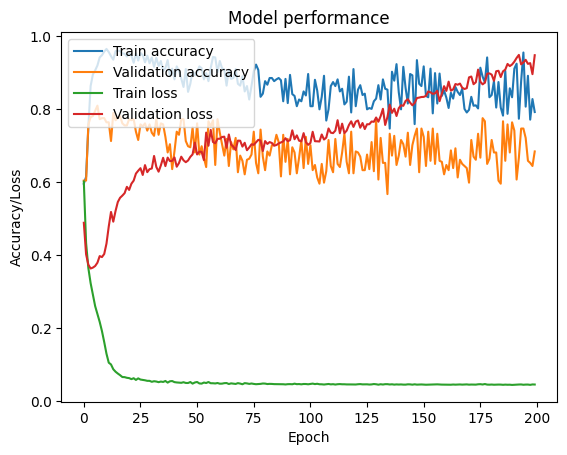

In [73]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model performance')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Validation accuracy', 'Train loss', 'Validation loss'], loc='upper left')
plt.show()


In [74]:
# Load the model
loaded_model = load_model('my_model.h5')

# Evaluate the model on the test set
loss, accuracy = loaded_model.evaluate(X_test, y_test, batch_size=32)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy, '\n')


# Predict the test set
y_pred = loaded_model.predict(X_test)

# Convert the predicted probabilities to binary labels
y_pred_binary = (y_pred > 0.5).astype(int)

# Print the classification report
print(classification_report(y_test, y_pred_binary, target_names=target_names))

11/11 [==============================] - 0s 1ms/step - loss: 0.9472 - accuracy: 0.6838
Test Loss: 0.947220504283905
Test Accuracy: 0.6837607026100159 

                     precision    recall  f1-score   support

            sarcasm       0.79      0.84      0.82       212
              irony       0.71      0.68      0.70       139
             satire       0.77      0.87      0.82        23
     understatement       0.84      0.93      0.88        28
      overstatement       0.71      0.67      0.69        30
rhetorical_question       0.79      0.43      0.55        61

          micro avg       0.77      0.74      0.75       493
          macro avg       0.77      0.74      0.74       493
       weighted avg       0.76      0.74      0.75       493
        samples avg       0.75      0.73      0.72       493



In [79]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [75]:
import tensorflow as tf

In [83]:
text_sample_vector

<1x200 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [132]:
import re

In [133]:
def clean_text(text):
    text = text.replace('[^\w\s]', '')  # getting rid of special characters
    text = text.replace('\d+', '')  # removing numeric values from between the words
    text = re.sub(r'\d+', '', text)  # removing numerical numbers
    text = " ".join(x.lower() for x in text.split())  # lower case conversion
    stop = stopwords.words('english')
    text = " ".join(x for x in text.split() if x not in stop)  # removing stop words
    stemmer = WordNetLemmatizer()
    text = " ".join([stemmer.lemmatize(word) for word in text.split()])  # converting words to their dictionary form
    return text

In [134]:
text = "@jimrossignol I choose to interpret it as XD: the universal emoticon for laughing at those poor, poor folks in Ubisoft's marketing department who have to deal with that branding until the servers quietly shut down 8 months after launch."
text = clean_text(text)
# Load the TfidfVectorizer object
with open('tfidf_vectorizer.pkl', 'rb') as f:
    loaded_tfidf_vectorizer = pickle.load(f)
    
text_sample_vector = loaded_tfidf_vectorizer.transform([text])

In [135]:
text_sample_vector = text_sample_vector.toarray()[0]

In [136]:
import numpy as np
text_sample_vector = np.reshape(text_sample_vector, (1, 200))

In [137]:
predictions = loaded_model.predict(text_sample_vector)

In [138]:
# Convert the predicted probabilities to binary labels
sample_pred = (predictions > 0.5).astype(int)

In [150]:
sample_pred = np.array(sample_pred[0])

In [151]:
target_names = np.array(['sarcasm',
 'irony',
 'satire',
 'understatement',
 'overstatement',
 'rhetorical_question'])

In [152]:
sample_pred[0]

0

In [157]:
labels_sampel = list(target_names[sample_pred == 1])

In [158]:
' , '.join(labels_sampel)

'irony , understatement'

In [166]:
' , '.join(labels_sampel) if len(labels_sampel) > 1 else labels_sampel[0] 

'irony'

In [164]:
len(labels_sampel)

2

In [165]:
labels_sampel.pop()

'understatement'